# Feature Matching 


Please use tensorflow 1.3

In [14]:
# image_paths = ['./data/oxford5k_images/hertford_000056.jpg']

%load_ext autoreload
%autoreload 2
from delf.examples import extract_features
from delf.examples import match_images
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from PIL import Image
from io import BytesIO

import os 
import random
import string

TEMP_DIR = './temp_image/'

helper = extract_features.InferenceHelper('./delf/examples/delf_config_example.pbtxt')

def resize_image(image, target_size=800):
  def calc_by_ratio(a, b):
    return int(a * target_size / float(b))

  size = image.size
  if size[0] < size[1]:
    w = calc_by_ratio(size[0], size[1])
    h = target_size
  else:
    w = target_size
    h = calc_by_ratio(size[1], size[0])

  # image = image.resize((w, h), Image.BILINEAR)
  image = image.resize((w, h), Image.ANTIALIAS)
  return image


def get_and_cache_image(image_path, basewidth=None):
    image = Image.open(image_path)
    if basewidth is not None:
        image = resize_image(image, basewidth)
    imgByteArr = BytesIO()
    image.save(imgByteArr, format='PNG')
    imgByteArr = imgByteArr.getvalue()
    
    fname = ''.join(random.choice(string.ascii_lowercase + string.digits) for x in range(6))
    image_path = TEMP_DIR+'{}.png'.format(fname)
    if os.path.exists(image_path):
        os.remove(image_path)
    image.save(image_path, format='PNG')

    return image_path, imgByteArr

def get_result(image_paths, size=None):
    resize_image_paths = []
    resize_image_bytes = []
    for i in range(2):
        path, byte = get_and_cache_image(image_paths[i], size)
        resize_image_paths.append(path)
        resize_image_bytes.append(byte)
    
    location_np_list, descriptor_np_list, feature_scale_np_list, attention_score_np_list, attention_np_list = \
        helper.get_feature_from_bytes(resize_image_bytes)
    print("location_np_list shape:", location_np_list[0].shape) # (1000, 2) Q. x,y or y,x ?
    print("location_np_list:", location_np_list[0])
    print("descriptor_np_list shape:", descriptor_np_list[0].shape) # (1000, 40) 40d local descriptor
    print("descriptor_np_list:", descriptor_np_list[0])
    print("feature_scale_np_list shape:", feature_scale_np_list[0].shape) # (1000, ) keypoint addtional info 
    print("feature_scale_np_list:", feature_scale_np_list[0])
    print("attention_score_np_list shape:", attention_score_np_list[0].shape) # (1000, ) keypoint addtional info 
    print("attention_score_np_list:", attention_score_np_list[0])
    print("attention_np_list shape:", attention_np_list[0].shape) # (1, width, height, 1) attention map
    print("attention_np_list:", attention_np_list[0])
    
        

    attention_image_byte_img1 = match_images.get_attention_image_byte(attention_np_list[0])
    attention_image_byte_img2 = match_images.get_attention_image_byte(attention_np_list[1])
        
    side_by_side_comp_img_byte, score = match_images.get_ransac_image_byte(resize_image_bytes[0], location_np_list[0], descriptor_np_list[0], resize_image_bytes[1], location_np_list[1], descriptor_np_list[1])
    print('matching inliner num:', score)
    return side_by_side_comp_img_byte, attention_image_byte_img1, attention_image_byte_img2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
INFO:tensorflow:Creating model resnet_v1_50/block3 
INFO:tensorflow:Creating model resnet_v1_50/block3 
INFO:tensorflow:Creating model resnet_v1_50/block3 
INFO:tensorflow:Restoring parameters from parameters/delf_v1_20171026/model/variables/variables


INFO:tensorflow:done! Found 2 images
location_np_list shape: (1000, 2)
location_np_list: [[ 176.  528.]
 [ 720.  720.]
 [ 176.  512.]
 ..., 
 [ 496.  256.]
 [ 672.   16.]
 [ 256.    0.]]
descriptor_np_list shape: (1000, 40)
descriptor_np_list: [[-0.01932149 -0.29479104  0.57953221 ...,  0.07308254 -0.16533552
   0.01831841]
 [ 0.05549924  0.04316742  0.33359486 ..., -0.07332238  0.05927621
  -0.25642717]
 [ 0.0636522  -0.35411614  0.64317602 ...,  0.07214111 -0.12358805
   0.01670169]
 ..., 
 [-0.06533604  0.13719121 -0.20726047 ...,  0.19264407  0.05137365
  -0.05820682]
 [-0.29001847  0.35257968  0.18337511 ..., -0.05738787  0.01741232
   0.16510877]
 [-0.47155768 -0.03985843  0.03242248 ...,  0.26309079  0.17679887
  -0.0110516 ]]
feature_scale_np_list shape: (1000,)
feature_scale_np_list: [ 0.5         0.5         0.5         0.5         0.70711356  1.          4.
  0.70711356  0.5         0.70711356  0.5         0.70711356  0.70711356
  0.5         2.82805443  0.70711356  4.      

matching inliner num: 94


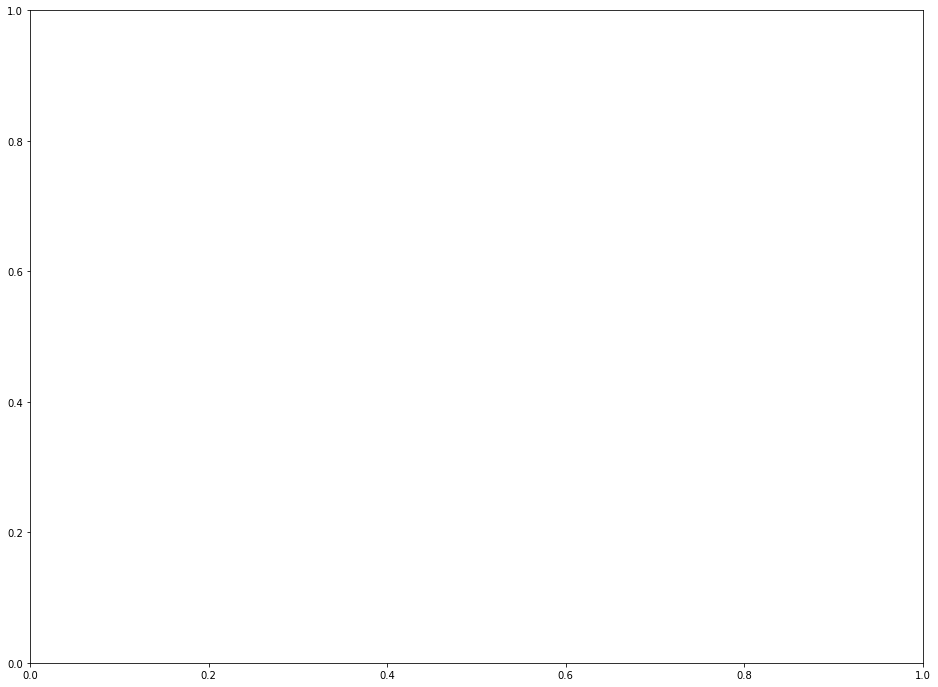

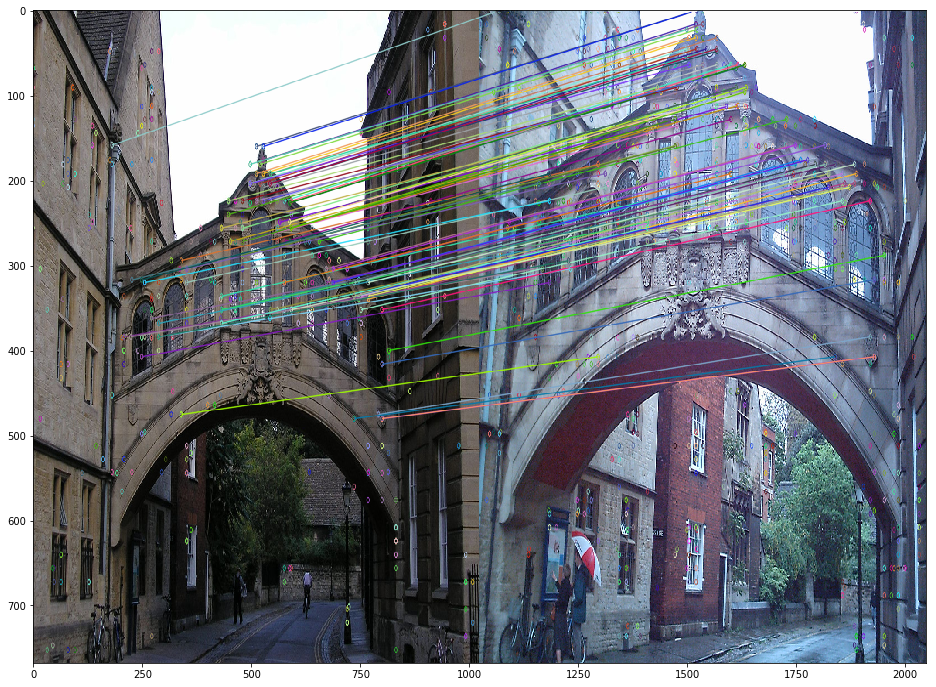

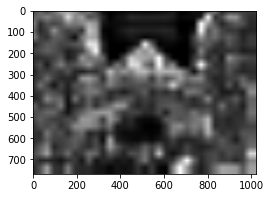

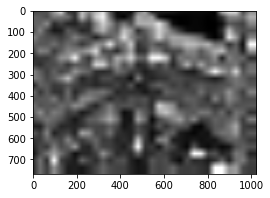

In [15]:
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image
%matplotlib inline
image_paths = ['./oxf5k_images/hertford_000056.jpg', './oxf5k_images/oxford_000317.jpg']
result_image_byte, att1, att2 = get_result(image_paths)

plt.figure(figsize=(16,12))
result_image = Image.open(BytesIO(result_image_byte))
imshow(np.asarray(result_image), aspect='auto')

plt.figure(figsize=(4,3))
att1_image = Image.open(BytesIO(att1))
imshow(np.asarray(att1_image), aspect='auto')

plt.figure(figsize=(4,3))
att2_image = Image.open(BytesIO(att2))
imshow(np.asarray(att2_image), aspect='auto')

INFO:tensorflow:done! Found 2 images


/home/naver/.local/lib/python3.5/site-packages/skimage/transform/_geometric.py:684: RuntimeWarning: divide by zero encountered in true_divide
  H.flat[list(self._coeffs) + [8]] = - V[-1, :-1] / V[-1, -1]
/home/naver/.local/lib/python3.5/site-packages/skimage/measure/fit.py:931: RuntimeWarning: invalid value encountered in less
  sample_model_inliers = sample_model_residuals < residual_threshold
/home/naver/.local/lib/python3.5/site-packages/skimage/transform/_geometric.py:684: RuntimeWarning: invalid value encountered in true_divide
  H.flat[list(self._coeffs) + [8]] = - V[-1, :-1] / V[-1, -1]


matching inliner num: 36


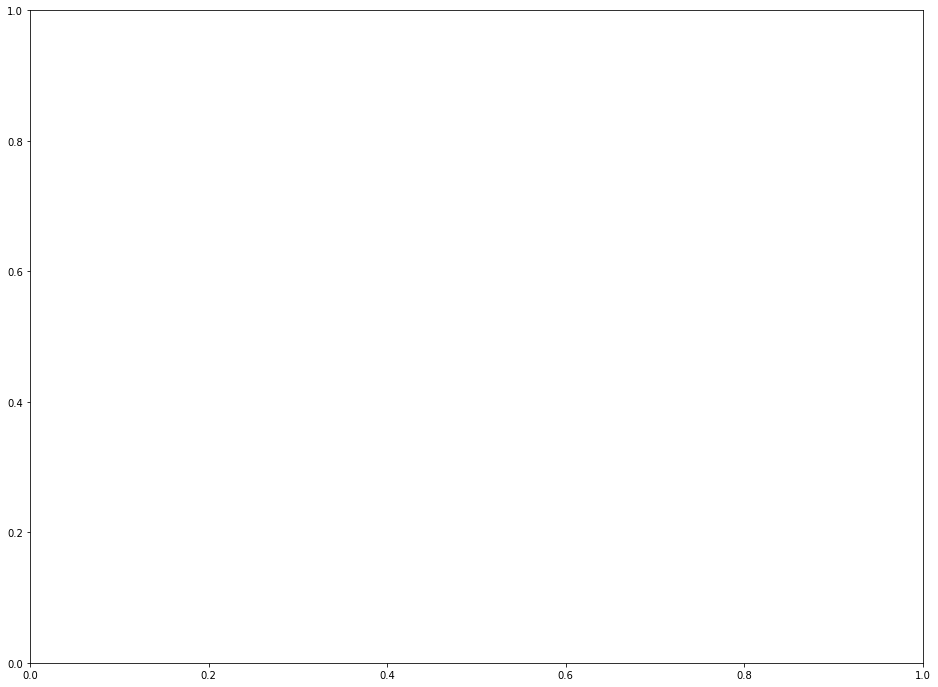

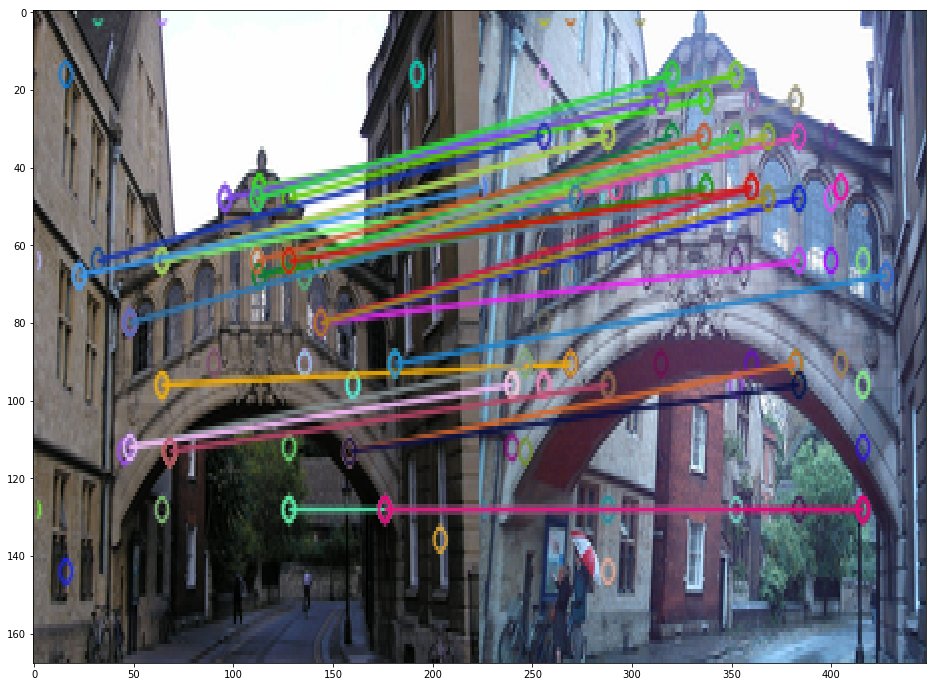

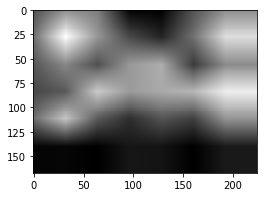

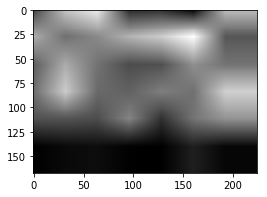

In [7]:
image_paths = ['./oxf5k_images/hertford_000056.jpg', './oxf5k_images/oxford_000317.jpg']
result_image_byte, att1, att2 = get_result(image_paths, size=224)

plt.figure(figsize=(16,12))
result_image = Image.open(BytesIO(result_image_byte))
imshow(np.asarray(result_image), aspect='auto')

plt.figure(figsize=(4,3))
att1_image = Image.open(BytesIO(att1))
imshow(np.asarray(att1_image), aspect='auto')

plt.figure(figsize=(4,3))
att2_image = Image.open(BytesIO(att2))
imshow(np.asarray(att2_image), aspect='auto')

# Pisa 
Demo to see the power of attention

INFO:tensorflow:done! Found 2 images


/home/naver/.local/lib/python3.5/site-packages/skimage/transform/_geometric.py:684: RuntimeWarning: divide by zero encountered in true_divide
  H.flat[list(self._coeffs) + [8]] = - V[-1, :-1] / V[-1, -1]
/home/naver/.local/lib/python3.5/site-packages/skimage/measure/fit.py:931: RuntimeWarning: invalid value encountered in less
  sample_model_inliers = sample_model_residuals < residual_threshold
/home/naver/.local/lib/python3.5/site-packages/skimage/transform/_geometric.py:684: RuntimeWarning: invalid value encountered in true_divide
  H.flat[list(self._coeffs) + [8]] = - V[-1, :-1] / V[-1, -1]


matching inliner num: 72


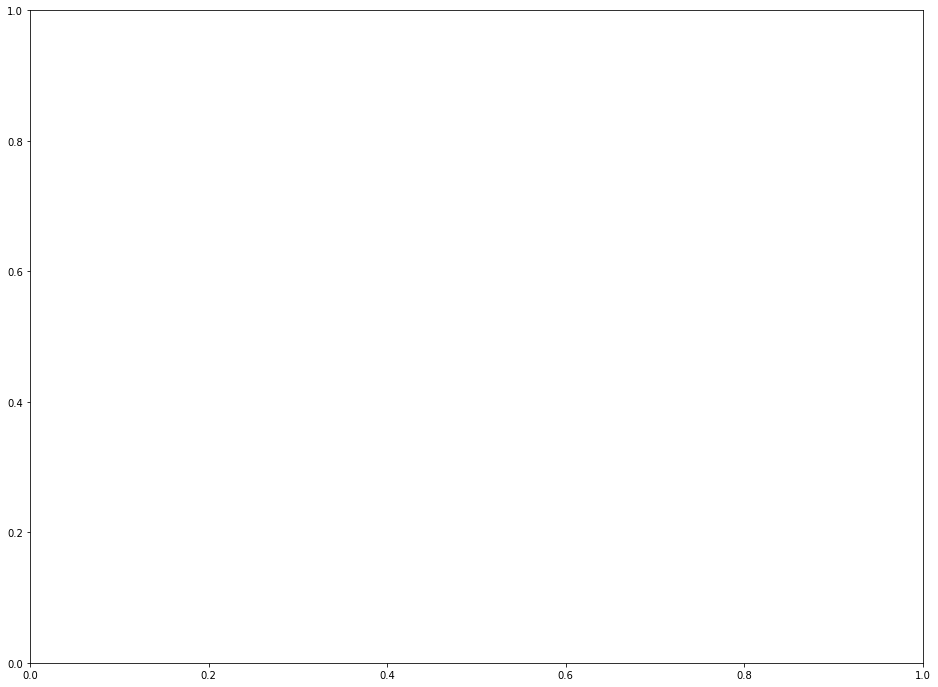

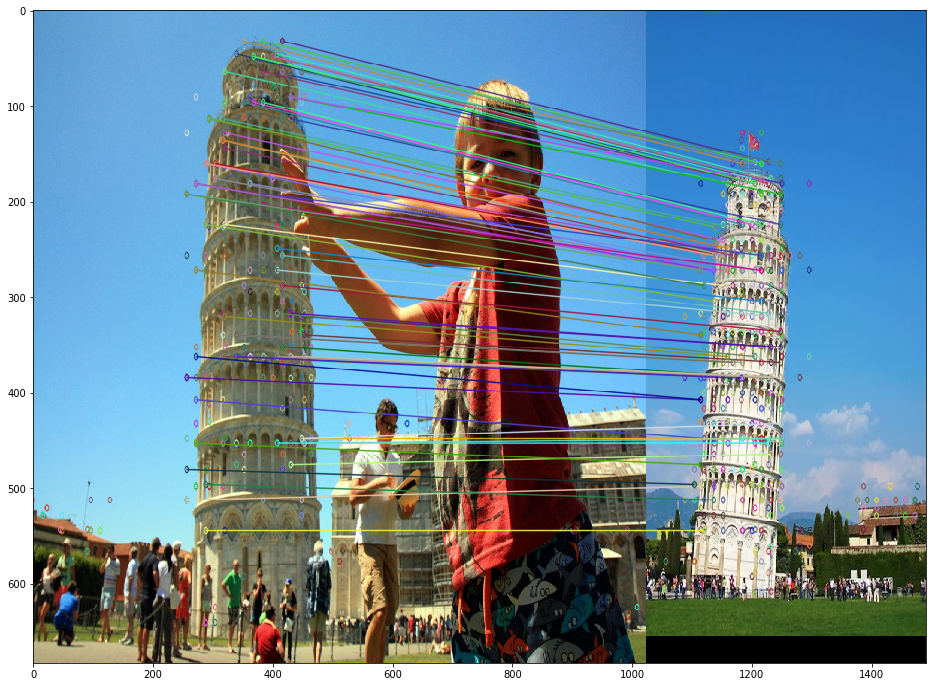

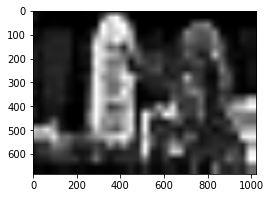

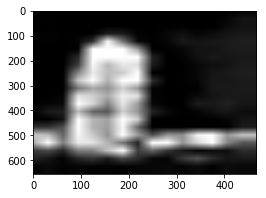

In [9]:
image_paths = ['./test_images/pisa_query.jpg', './test_images/pisa_answer.jpg']
result_image_byte, att1, att2 = get_result(image_paths)

plt.figure(figsize=(16,12))
result_image = Image.open(BytesIO(result_image_byte))
imshow(np.asarray(result_image), aspect='auto')

plt.figure(figsize=(4,3))
att1_image = Image.open(BytesIO(att1))
imshow(np.asarray(att1_image), aspect='auto')

plt.figure(figsize=(4,3))
att2_image = Image.open(BytesIO(att2))
imshow(np.asarray(att2_image), aspect='auto')

# Milktea

Demo to see whether it works on non-building images

INFO:tensorflow:done! Found 2 images


/home/naver/.local/lib/python3.5/site-packages/skimage/transform/_geometric.py:684: RuntimeWarning: divide by zero encountered in true_divide
  H.flat[list(self._coeffs) + [8]] = - V[-1, :-1] / V[-1, -1]
/home/naver/.local/lib/python3.5/site-packages/skimage/measure/fit.py:931: RuntimeWarning: invalid value encountered in less
  sample_model_inliers = sample_model_residuals < residual_threshold


matching inliner num: 21


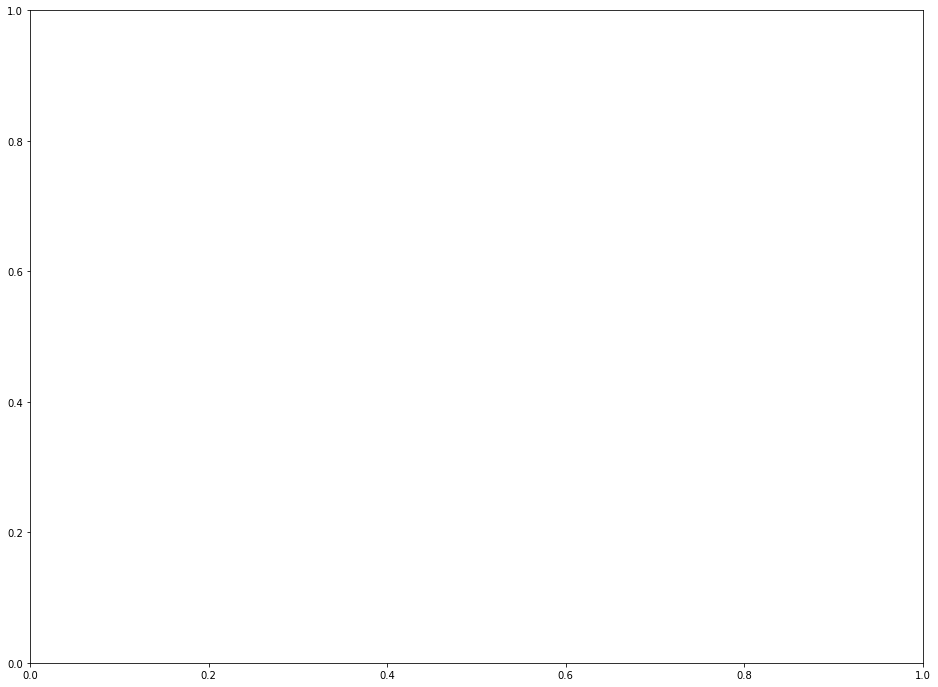

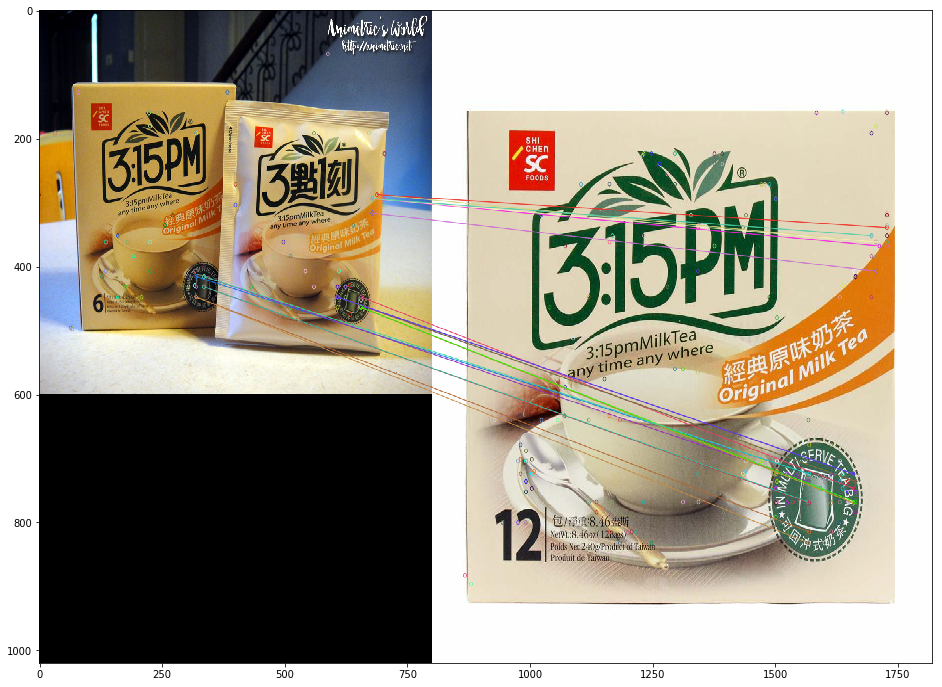

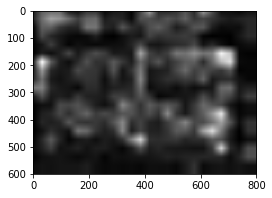

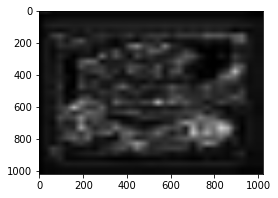

In [10]:
image_paths = ['./test_images/milktea_query.jpg', './test_images/milktea_answer.jpg']
result_image_byte, att1, att2 = get_result(image_paths)

plt.figure(figsize=(16,12))
result_image = Image.open(BytesIO(result_image_byte))
imshow(np.asarray(result_image), aspect='auto')

plt.figure(figsize=(4,3))
att1_image = Image.open(BytesIO(att1))
imshow(np.asarray(att1_image), aspect='auto')

plt.figure(figsize=(4,3))
att2_image = Image.open(BytesIO(att2))
imshow(np.asarray(att2_image), aspect='auto')

INFO:tensorflow:done! Found 2 images


/home/naver/.local/lib/python3.5/site-packages/skimage/transform/_geometric.py:684: RuntimeWarning: divide by zero encountered in true_divide
  H.flat[list(self._coeffs) + [8]] = - V[-1, :-1] / V[-1, -1]
/home/naver/.local/lib/python3.5/site-packages/skimage/measure/fit.py:931: RuntimeWarning: invalid value encountered in less
  sample_model_inliers = sample_model_residuals < residual_threshold


matching inliner num: 22


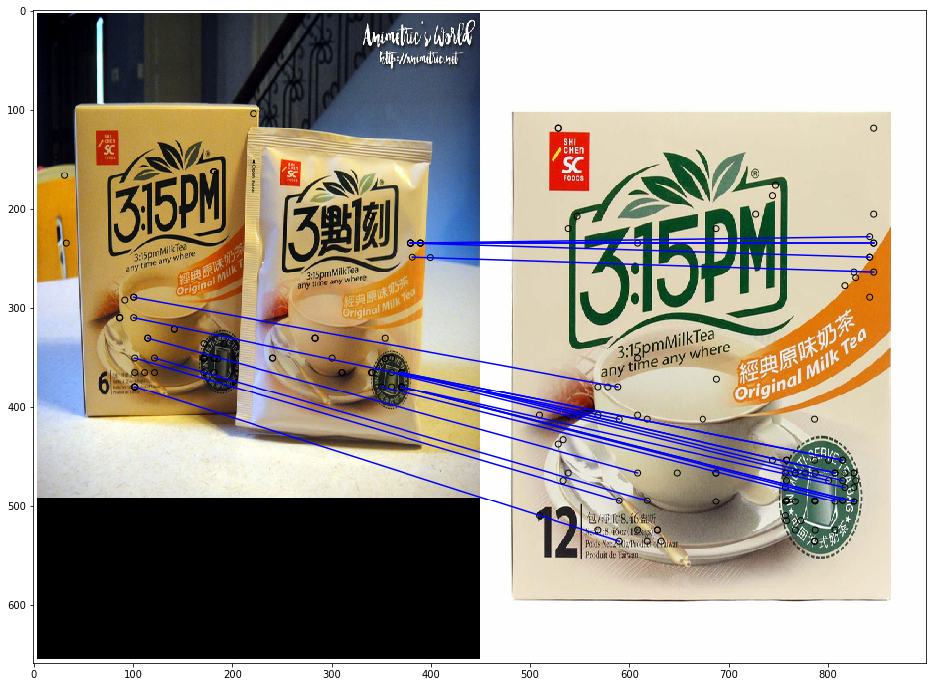

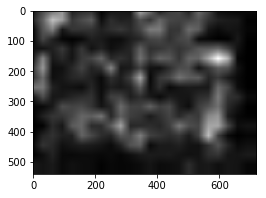

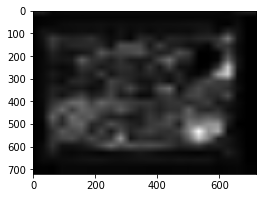

In [11]:
image_paths = ['./test_images/milktea_query.jpg', './test_images/milktea_answer.jpg']
result_image_byte, att1, att2 = get_result(image_paths, size=720)

plt.figure(figsize=(16,12))
result_image = Image.open(BytesIO(result_image_byte))
imshow(np.asarray(result_image), aspect='auto')

plt.figure(figsize=(4,3))
att1_image = Image.open(BytesIO(att1))
imshow(np.asarray(att1_image), aspect='auto')

plt.figure(figsize=(4,3))
att2_image = Image.open(BytesIO(att2))
imshow(np.asarray(att2_image), aspect='auto')

# Hand Holding

Demo to see if attention trained on building imageset can attend on target product

INFO:tensorflow:done! Found 2 images


/home/naver/.local/lib/python3.5/site-packages/skimage/transform/_geometric.py:684: RuntimeWarning: divide by zero encountered in true_divide
  H.flat[list(self._coeffs) + [8]] = - V[-1, :-1] / V[-1, -1]
/home/naver/.local/lib/python3.5/site-packages/skimage/measure/fit.py:931: RuntimeWarning: invalid value encountered in less
  sample_model_inliers = sample_model_residuals < residual_threshold
/home/naver/.local/lib/python3.5/site-packages/skimage/transform/_geometric.py:684: RuntimeWarning: invalid value encountered in true_divide
  H.flat[list(self._coeffs) + [8]] = - V[-1, :-1] / V[-1, -1]


matching inliner num: 37


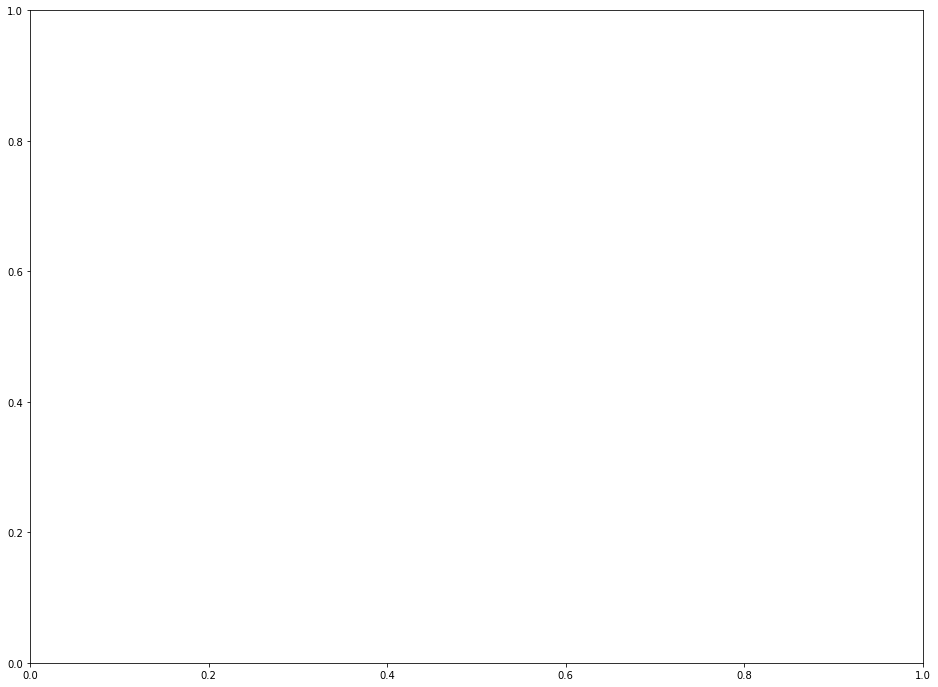

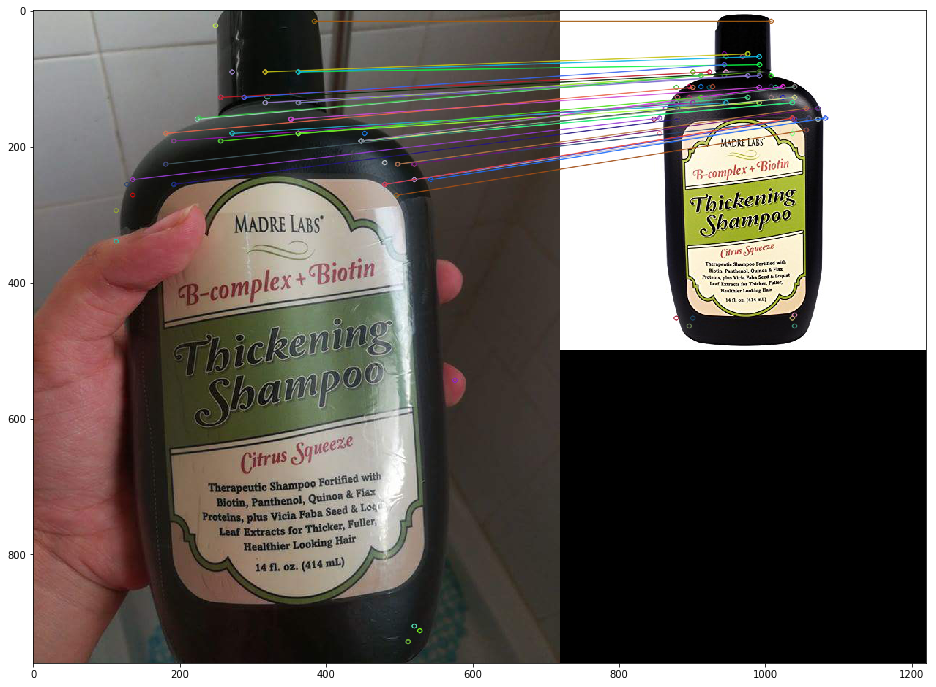

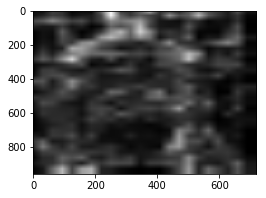

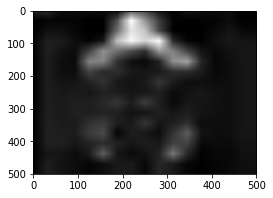

In [11]:
image_paths = ['./test_images/shampoo_query.jpg', './test_images/shampoo_answer.jpg']
result_image_byte, att1, att2 = get_result(image_paths)

plt.figure(figsize=(16,12))
result_image = Image.open(BytesIO(result_image_byte))
imshow(np.asarray(result_image), aspect='auto')

plt.figure(figsize=(4,3))
att1_image = Image.open(BytesIO(att1))
imshow(np.asarray(att1_image), aspect='auto')

plt.figure(figsize=(4,3))
att2_image = Image.open(BytesIO(att2))
imshow(np.asarray(att2_image), aspect='auto')